<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/Quark_gluon_study_CNN_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%%capture
pip install pennylane jax jaxlib

In [10]:
import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt

In [15]:
test = h5py.File("/content/QG_16x16x1_dataset_50k","r")
x_s = test.get('X')
y_s = test.get('y')

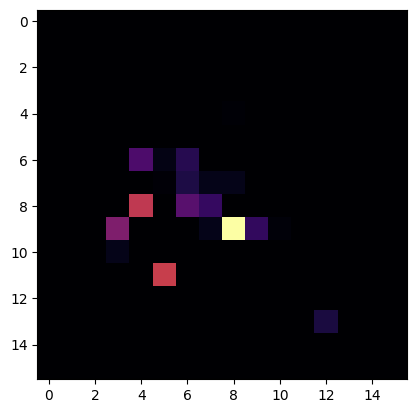

In [17]:
plt.imshow(x_s[0], cmap='inferno')
plt.show()

In [18]:
def preprocess_jnp(
    classes: jnp.ndarray, trainloader: DataLoader, testloader: DataLoader
):
    r"""Load Data from PyTorch DataLoader into JAX NumPy Arrays

    Args:
        classes (jnp.ndarray) : List of integers representing data classes to be loaded.
            If None, return all classes.
        trainloader (torch.utils.data.DataLoader) : Trainset loader.
        testloader (torch.utils.data.DataLoader) : Testset loader.

    Returns:
        Tuple[jnp.ndarray, ...]: Tuple of training and test data/labels. The outputs are
        ordered as follows:

        * ``X_train``: Training samples of shape ``(num_train, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Training labels of shape ``(num_train, )``.
        * ``X_test``: Test samples of shape ``(num_test, img_size, img_size,
          num_channel)``.
        * ``Y_train``: Test labels of shape ``(num_test, )``.
    """
    X_train = []
    Y_train = []

    X_test = []
    Y_test = []

    print(classes)
    # Load data as a np.ndarray
    for i, data in enumerate(trainloader, 0):
        image, label = data
        X_train.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_train.extend(list(label.detach().numpy()))

    for i, data in enumerate(testloader, 0):
        image, label = data
        X_test.extend(list(jnp.transpose(image.detach().numpy(), (0, 2, 3, 1))))
        Y_test.extend(list(label.detach().numpy()))

    X_train = jnp.array(X_train)
    Y_train = jnp.array(Y_train)

    X_test = jnp.array(X_test)
    Y_test = jnp.array(Y_test)

    if classes is not None:
        train_mask = np.isin(Y_train, classes)
        X_train = X_train[train_mask]
        Y_train = Y_train[train_mask]

        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[0])].set(0.0)
        Y_train = Y_train.at[jnp.argwhere(Y_train == classes[1])].set(1.0)

        test_mask = np.isin(Y_test, classes)
        X_test = X_test[test_mask]
        Y_test = Y_test[test_mask]
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[0])].set(0.0)
        Y_test = Y_test.at[jnp.argwhere(Y_test == classes[1])].set(1.0)

    return X_train, Y_train, X_test, Y_test


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import h5py
from sklearn.model_selection import train_test_split

class CustomDatasetFromHDF5(Dataset):
    def __init__(self, path, transform=None):
        with h5py.File(path, "r") as file:
            self.data = file["X"][:]
            self.labels = file["y"][:]
        self.transform = transform

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.labels)

img_size = 16

# Definir transformaciones
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

# Crear dataset
data = CustomDatasetFromHDF5("/content/QG_16x16x1_dataset_50k", transform=transform)

# Dividir el dataset en entrenamiento y prueba
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_ds, test_ds = torch.utils.data.random_split(data, [train_size, test_size])

# Crear dataloaders
trainloader = DataLoader(train_ds, batch_size=1000, shuffle=True)
testloader = DataLoader(test_ds, batch_size=1000, shuffle=True)


In [21]:
classes = [0,1]
X_train, Y_train, X_test, Y_test = preprocess_jnp(
            classes, trainloader, testloader
        )

[0, 1]


/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float32 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible

In [23]:
from collections import Counter

# Contadores para etiquetas
label_counts = Counter()

# Iterar sobre el dataloader
for _, labels in trainloader:
    label_counts.update(labels.numpy())

total_train = sum(label_counts.values())
count_0 = label_counts[0]
count_1 = label_counts[1]

print(f"Total de datos en entrenamiento: {total_train}")
print(f"Total de etiquetas 0: {count_0}")
print(f"Total de etiquetas 1: {count_1}")

Total de datos en entrenamiento: 40000
Total de etiquetas 0: 20023
Total de etiquetas 1: 19977


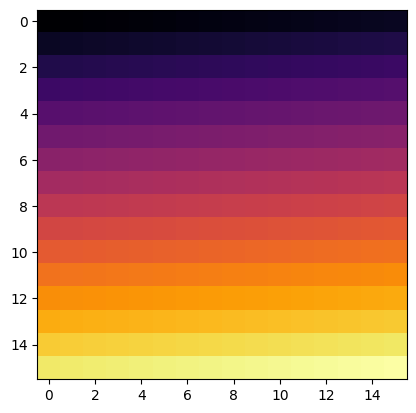

In [24]:
example = np.arange(256).reshape(16, 16)
plt.imshow(example, cmap='inferno')
plt.show()

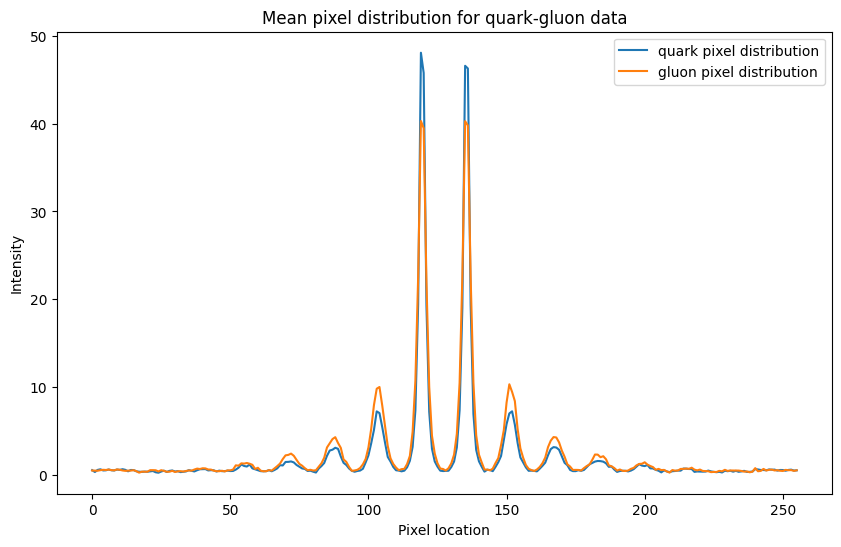

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# split quark and gluon data
quark = X_train[Y_train == 1]
gluon = X_train[Y_train == 0]


# flat data
quark_flat = np.array([img.reshape(16*16) for img in quark[:]])
gluon_flat = np.array([img.reshape(16*16) for img in gluon[:]])

# calculate the mean value per pixel in each kind of data
average_quark_pixel_values = np.mean(quark_flat, axis=0) * 255  # Escalamos por 255
average_gluon_pixel_values = np.mean(gluon_flat, axis=0) * 255  # Escalamos por 255

# Create a dataframe with the mean values for gluon and quark data and a list with all the pixels
df = {"pixel": np.arange(256), "quark_value": average_quark_pixel_values, "gluon_value": average_gluon_pixel_values}
df = pd.DataFrame(df)

# plot the distributions
plt.figure(figsize=(10, 6))
plt.plot(df["pixel"], df["quark_value"], label = "quark pixel distribution")
plt.plot(df["pixel"], df["gluon_value"], label = "gluon pixel distribution")
plt.xlabel('Pixel location')
plt.ylabel('Intensity')
plt.title('Mean pixel distribution for quark-gluon data')
plt.legend()
plt.show()



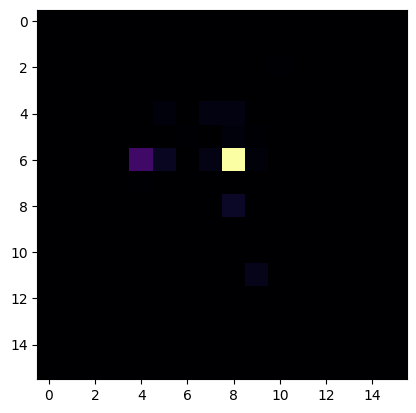

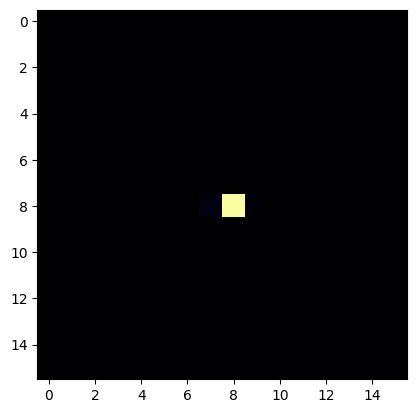

In [37]:
plt.imshow(quark[0], cmap='inferno')
plt.show()
plt.imshow(gluon[0], cmap='inferno')
plt.show()

Interpretation:

A first view, we can see that the two samples are quite similar,

**Statistics test**

**Kolmogorov-Smirnov test (KS)**

If the p-value is small (lower than 0.05), we can reject the null hypothesis that the two samples are from the same distribution.

**Chi-Square test ($\xi^2 $)**

In the same way, if the p-value is small indicates that is less probably that the two distributions are the same.



In [26]:
from scipy.stats import ks_2samp

# Aplicar la prueba de KS
ks_statistic, ks_p_value = ks_2samp(average_quark_pixel_values, average_gluon_pixel_values)
print(f'Prueba KS: estadístico = {ks_statistic}, p-valor = {ks_p_value}')


Prueba KS: estadístico = 0.14453125, p-valor = 0.009440529437020562


In [27]:
from scipy.stats import chi2_contingency

# Crear una tabla de contingencia
contingency_table = np.array([average_quark_pixel_values, average_gluon_pixel_values])

# Aplicar la prueba de Chi-cuadrado
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(contingency_table)
print(f'Prueba Chi-cuadrado: estadístico = {chi2_statistic}, p-valor = {chi2_p_value}')


Prueba Chi-cuadrado: estadístico = 15.156997095520637, p-valor = 1.0


## Classical CNN

In [32]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definir la arquitectura del modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(16, 16, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Para clasificación binaria
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [34]:
# Entrenar el modelo

history = model.fit(np.array(X_train), np.array(Y_train), epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
1000/1000 [==============================] - 12s 11ms/step - loss: 0.6836 - accuracy: 0.5595 - val_loss: 0.6758 - val_accuracy: 0.5769
Epoch 2/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6768 - accuracy: 0.5812 - val_loss: 0.6752 - val_accuracy: 0.5814
Epoch 3/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6741 - accuracy: 0.5870 - val_loss: 0.6720 - val_accuracy: 0.5916
Epoch 4/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6713 - accuracy: 0.5897 - val_loss: 0.6710 - val_accuracy: 0.5891
Epoch 5/50
1000/1000 [==============================] - 10s 10ms/step - loss: 0.6699 - accuracy: 0.5907 - val_loss: 0.6718 - val_accuracy: 0.5864
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6682 - accuracy: 0.5985 - val_loss: 0.6694 - val_accuracy: 0.5886
Epoch 7/50
1000/1000 [==============================] - 11s 11ms/step - loss: 0.6664 - accuracy: 0.5987 - val_loss: 0.6693 - v

313/313 [==============================] - 1s 4ms/step - loss: 0.7919 - accuracy: 0.5780
Test accuracy: 0.578000009059906


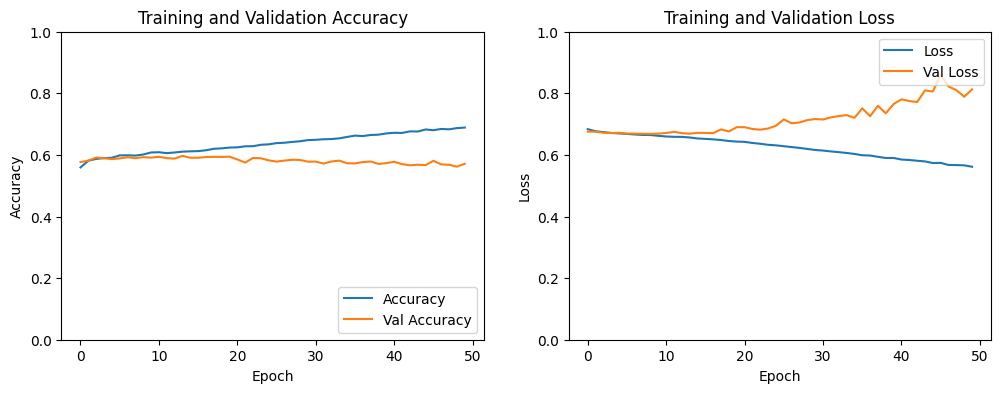

In [36]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(np.array(X_test), np.array(Y_test))
print(f'Test accuracy: {test_acc}')

# Graficar las métricas de entrenamiento
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
